In [1]:
import os
import nltk
import csv
from matplotlib.pyplot import cm
import numpy as np
from nltk.corpus import stopwords
import math

import matplotlib.pyplot as plt


from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords
from wordcloud import WordCloud

from bs4 import BeautifulSoup
from community import community_louvain
from fa2 import ForceAtlas2

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Sentiment Analysis
>We want to be able to analyse the sentiment of a character throughout the books. Our idea for achieving this is to use concordance from nltk with the character name, this way we will get all of the context surrounding a character. For each of these occurrences we can compute the sentiment for the context, and use that sentiment as a representative for the character. 

/home/peter/.local/lib/python3.10/site-packages/nltk/draw/__init__.py:15: UserWarning: nltk.draw package not loaded (please install Tkinter library).
  warnings.warn("nltk.draw package not loaded (please install Tkinter library).")


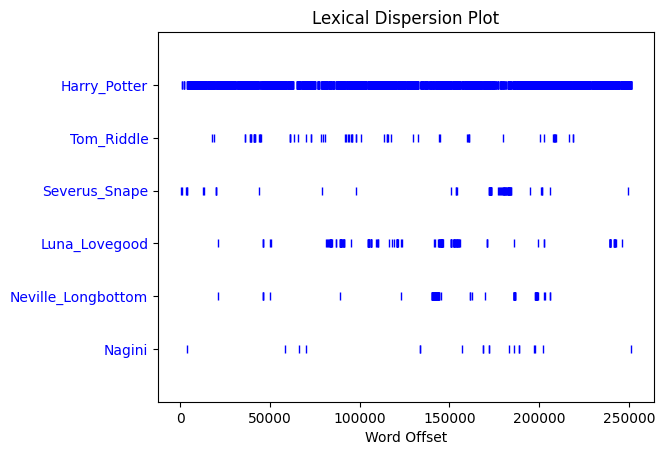

In [2]:
# Does not belong here, maybe usufull for arguing about normalizing harry potter weights in graphs?
tokens = []
for chapter in os.listdir("B7/"):
    if "replaced" in chapter:
        f = open("B7/" + chapter)
        raw = f.read()
        tokens += nltk.wordpunct_tokenize(raw)
text = nltk.Text(tokens)

text.dispersion_plot(["Harry_Potter", "Tom_Riddle", "Severus_Snape", "Luna_Lovegood", "Neville_Longbottom", "Nagini"])

## Sentiment calculations from LabMT1.0 vs VADER-Sentiment
>We have considered two options for calculating our sentiment. Either we could use the the LabMT1.0 data set to find the sentiment of a portion of text by assigning each word in that text a value based on LabMT1.0, and then taking the average of those words. Or we could use <a href="https://github.com/cjhutto/vaderSentiment/blob/master/README.rst">VADER-Sentiment</a>. We wanted to experiment with the VADER solution, since our initial findings for sentiment using LabMT1.0 had very similar values around 5.5. To experiment we have made a graph of sentiments for each chapter of Book 7, for Harry Potter, Voldemort, and Snape for both methods:

###  Sentiment for concordance of character, LabMT1.0
> First we create a list of tuples containing each word and the average happiness for that word. This allows us to go through a portion of text and look up the average happiness for each word.

In [3]:
# Create an empty list to store tuples of words and their 
# average happiness score
sent_list = []

# Read in the .tsv file
with open("LabMT1.0.tsv", "r", encoding="utf8") as sent_file:
    tsv_reader = csv.DictReader(sent_file, delimiter="\t")
    # For each sentiment in the file, save the word and average happiness in a tuple
    # and add it to the list
    for sent in tsv_reader:
        word = sent["word"]
        average = sent["happiness_average"]
        sent_list.append((word, average))

>We now define a function to calculate the average sentiment for a set of tokens:

In [4]:
# Defining function to calculate sentiment for a list of tokens
# Function for calculating the sentiment of a file from the frequency distribution for that file
def sentiment(tokens):
    # Total sentiment score of file
    sent_sum = 0.0
    # Total number of occurences of words
    occ_sum = 0
    
    # For each token and associated number of occurences
    for token, occ in tokens.items():
        # If the token is in the given list of words with rated happiness
        for word, score in sent_list:
            if token == word:
                sent_sum += (float(score) * occ)
                occ_sum += occ
    return sent_sum / occ_sum


>And a function to calculate the sentiment for a concordance list found by nltk, and define a list of stopwords to be filtered out:

In [5]:
stopwords = nltk.corpus.stopwords.words('english')

In [6]:
# Finding sentiment from a concordance list
def con_sentiment(con_list):
    sent_sum = 0
    line_num = 0
    for item in con_list:
        left = [ch.lower() for ch in item.left if ch.isalpha()]
        right = [ch.lower() for ch in item.right if ch.isalpha()]
        # Make left and right into one list and remove stopwords
        combined = [w for w in (left + right) if w not in stopwords]
        
        # Make frequency distribution 
        fd = nltk.FreqDist(combined)
        sent_sum += sentiment(fd)
        line_num += 1
    if line_num == 0:
        return None # Character had no appearences in chapter
    return sent_sum / line_num

>We then run our test as described previously:

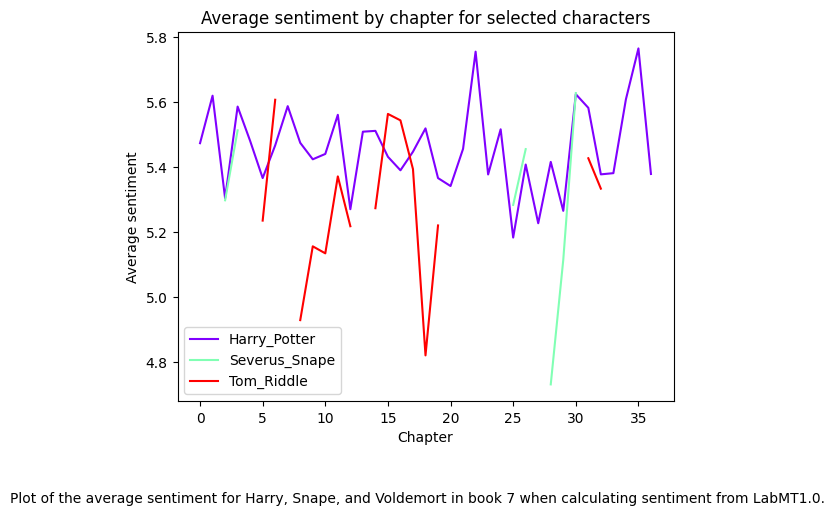

In [7]:
# Define character list with the three characteres
char_list = ["Harry_Potter", "Severus_Snape", "Tom_Riddle"] 

# Create a list of the chapters of book 7
chapters = os.listdir("B7")

# Init a list to tuples (chraracter, [sentiments for each chapter for that character])
sentiment_by_character = []

# For each of the characters
for character in char_list:
    sentiments = []
    # For each chapter
    for chapter in chapters:
        # Read in and tokenize the chapter
        if "replaced" in chapter:
            with open("B7/" + chapter) as f:
                    raw = f.read()
            tokens = nltk.wordpunct_tokenize(raw)
            text = nltk.Text(tokens)
        
            # Make concordance for that character
            con = text.concordance_list(character)
        
            # Calculate sentiments and append to the list for that character
            sentiments.append(con_sentiment(con))
    # Append the character with its full sentiment list
    sentiment_by_character.append((character, sentiments))

# https://stackoverflow.com/questions/4971269/how-to-pick-a-new-color-for-each-plotted-line-within-a-figure-in-matplotlib
color = iter(cm.rainbow(np.linspace(0, 1, len(char_list))))

for name, sentiments in sentiment_by_character:
    c = next(color)
    plt.plot(sentiments, c=c, label=name)

plt.legend()
plt.xlabel('Chapter')
plt.ylabel('Average sentiment')
plt.title('Average sentiment by chapter for selected characters')
plt.figtext(.5, -0.1, f"Plot of the average sentiment for Harry, Snape, and Voldemort in book 7 when calculating sentiment from LabMT1.0.", ha="center")

plt_labmt = plt

### Sentiment for concordance of character, vaderSentiment
>For VADER we use the same approach and code, but we have to redefine how we calculate sentiment from concordance, since we just have to pass a string to the analyzer:

In [8]:
# Finding sentiment from a concordance list
def con_sentiment(con):
    sent_sum = 0
    line_num = 0
    combined = con.left + con.right
    combined = " ".join(combined)

    vs = analyzer.polarity_scores(combined)

    if vs == 0:
        return None # Character had no appearences in chapter
    return vs["compound"]

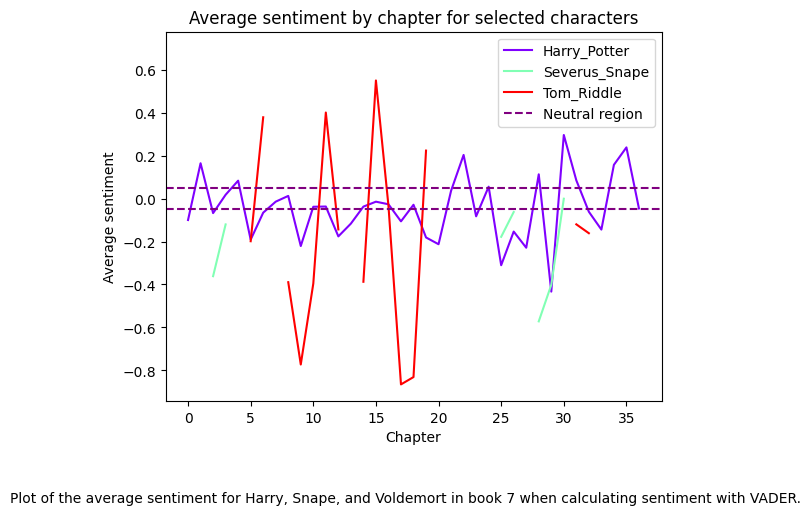

In [9]:
# Define character list with the three characteres
char_list = ["Harry_Potter", "Severus_Snape", "Tom_Riddle"] 

# Create a list of the chapters of book 7
chapters = os.listdir("B7")

# Init a list to tuples (chraracter, [sentiments for each chapter for that character])
sentiment_by_character = []

# For each of the characters
for character in char_list:
    sentiments = []
    for chapter in chapters:
        if "replaced" in chapter:
            with open("B7/" + chapter) as f:
                    raw = f.read()
            tokens = nltk.wordpunct_tokenize(raw)
            text = nltk.Text(tokens)
            cons = text.concordance_list(character)
            sent_sum = 0
            lines = 0
            for con in cons:
                sent_sum += con_sentiment(con)
                lines += 1
            if lines == 0:
                sentiments.append(None)
            else: 
                sentiments.append(sent_sum / lines)
    sentiment_by_character.append((character, sentiments))

# https://stackoverflow.com/questions/4971269/how-to-pick-a-new-color-for-each-plotted-line-within-a-figure-in-matplotlib
color = iter(cm.rainbow(np.linspace(0, 1, len(char_list))))

for name, sentiments in sentiment_by_character:
    c = next(color)
    plt.plot(sentiments, c=c, label=name)

plt.axhline(y = 0.05, color ="purple", linestyle = '--', label="Neutral region")
plt.axhline(y = -0.05, color ="purple", linestyle = '--')

plt.legend()
plt.xlabel('Chapter')
plt.ylabel('Average sentiment')
plt.title('Average sentiment by chapter for selected characters')
plt.figtext(.5, -0.1, f"Plot of the average sentiment for Harry, Snape, and Voldemort in book 7 when calculating sentiment with VADER.", ha="center")

plt_vader = plt

### Conclusion: LabMT1.0 vs vaderSentiment
>Both results are similar, but we see an advantage in using VADER when we consider the sentiment for Harry Potter. Looking at the graphs we can see that there are similar trends for Harry throughout the book, but with VADER the sentiment becomes more consistent, in that it appears to be in the neutral region at some points, and then go out of it. On the other hand the MatLab1.0 seems to indicate that Harry is well above 5.1 throughout the book, which we would consider to be above neutral. Based on this preliminary test we believe that we will get a more clear picture from VADER.

## Functions for calculating sentiment
>The following section contains various functions we have defined to find and plot sentiment for various cases.

### ```sent_chars_book(char_list, path_to_book)```
>The function takes a list of character names and a path to a book. It computes the average sentiment of each character in the list throughout the book on a chapter basis. This can be used to find out how the sentiment of a single character changes throughout a book or a group of characters such as a house.

In [10]:
"""
Input: A list of character names to look for as tokens
        and a path to the chapters of the book
Output: A list of tuples, with the character name and a list
        of the sentiments for each chapter for that character
"""
def sent_chars_book(char_list, path_to_book):
    # Read the list of chapters from the path
    chapters = os.listdir(path_to_book)

    # Init list to hold tuples
    sentiment_by_character = []
    
    # For each character in the given list
    for character in char_list:
        # Init list to hold sentiments for that character
        sentiments = []
        # For each chapter
        for chapter in chapters:
            if "replaced" in chapter:
                # Read in the chapter and tokenize
                with open(path_to_book + chapter) as f:
                    raw = f.read()
                tokens = nltk.wordpunct_tokenize(raw)
                text = nltk.Text(tokens)
                
                # Make concordance for that character in that chapter
                cons = text.concordance_list(character)
                
                sent_sum = 0
                lines = 0
                # For each concordance line
                for con in cons:
                    # Calculate the sentiment for that concordance line
                    sent_sum += con_sentiment(con)
                    lines += 1
                if lines == 0:
                    # If there were no lines, the character did not appear
                    sentiments.append(None)
                else: 
                    sentiments.append(sent_sum / lines)
        sentiment_by_character.append((character, sentiments))
    # Returns a list of the sentiments for that character for each chapter of that book
    return sentiment_by_character

### ```plot_sentiments(sentiment_by_character, figure_text, xs_vertical_lines, show_labels)```
>The functions takes a list of tuples, where each tuple contains a name and a list of sentiments. A figure text, a list of tuples for placing vertical lines with labels, and a ```True```/```False```flag for show labels. This function may take the result of ```sent_char_books``` a sinput for the list of tuples with names and sentiments. This allows for fast and simple plotting.

In [11]:
"""
Input: A list of tuples containing a name and a sentiment list, a figure text, 
       a list of tuples with labels and coordinates for vertical lines, and a
       true/false value for showing labels.
Output: void, shows a plot
"""
def plot_sentiments(sentiment_by_character, figure_text, xs_vertical_lines, show_legend):
    # Init iterator
    color = iter(cm.rainbow(np.linspace(0, 1, len(sentiment_by_character))))
    plt.margins(x=0)
    
    for name, sentiments in sentiment_by_character:
        # Try to give colors according to houses
        if ("Gryffindor" in name):
            c = "red"
            a = 0.5
        elif ("Slytherin" in name):
            c = "green"
            a = 1
        elif ("Hufflepuff" in name):
            c = "yellow"
            a = 1
        elif ("Ravenclaw" in name):
            c = "blue"
            a = 1
        else:
            c = next(color)
            a = 0.5
        plt.plot(sentiments, c=c, alpha=a, label=name)
    
    # Make horizontal lines to indicate the neutral region
    plt.axhline(y = 0.05, color ="purple", linestyle = '--')
    plt.axhline(y = -0.05, color ="purple", linestyle = '--')
    
    # If vertical lines for book has been specified insert them
    for book, vertical_line in xs_vertical_lines:
        plt.axvline(x = vertical_line, color = 'black')

    # If legend has been requested
    if show_legend:
        plt.legend()

    plt.xlabel('Chapter')
    plt.ylabel('Average sentiment')
    plt.figtext(.5, -0.1, figure_text, ha="center")

    plt.show()

### ```avgsent_group(char_sent_list)```
>This function finds the average sentiment for a group of characters. It takes a list of tuples containing a name and a list of sentiments for that character. It then goes through all of the sentiment lists finding the average for  that character from the sentiment values for each character that appeared in the that chapter. 

In [24]:
"""
Input: A list of tuples containing a name and a list of sentiments
       for that name. May take output of sent_chars_book as input.
Output: A list of the average sentiments for the given group. 
"""

def avgsent_group(group):
    # Init sentiment list
    avgsent_group = [0] * len(group[0][1])
    
    # Init list to hold number of characters that had sentiment value
    lines = [0] * len(group[0][1])
    
    # For each character have an index c
    for c in range(0,len(group)):
        # For each chapter have an index i
        for i in range(0, len(group[c][1])): # 
            if group[c][1][i] is not None:
                avgsent_group[i] += group[c][1][i]
                lines[i] += 1
    for i in range(len(avgsent_group)):
        if avgsent_group[i] == 0:
            avgsent_group[i] = None
        else:
            avgsent_group[i] = avgsent_group[i] / lines[i]
    return avgsent_group

### ```sent_book(path_to_book)```
>Calculates the sentiment for a book on chapter basis. In this function each chapter of a book is read in and the sentiment for the text is calculated. This allows us to see how the sentiment for a book changes as it progresses.

In [13]:
"""
Input: The path to a book.
Output: A list of sentiments for each chapter of the book.
"""
def sent_book(path_to_book):
    chapters = os.listdir(path_to_book)

    # Making a data table (char_list)x(num_chapters) to hold sentiments for each char in each chap
    # tuple list with tuples (character, [sent chapter1, sent chapter2, ...])
    sentiments_by_chapter = []
    
    for chapter in chapters:
        if "replaced" in chapter:
            with open(path_to_book + chapter) as f:
                raw = f.read()
            sentiments_by_chapter.append(analyzer.polarity_scores(raw)["compound"])
    # Returns a list of the sentiments for that character for each chapter of that book
    return sentiments_by_chapter

### ```sent_group_and_members(group, label_group, book_list)```
>This function calculates the sentiments for all of the names given in ```group``` and the average sentiment for those, and provides the average with the name from ```label_group```. The sentiments are calculated from the books given in ```book_list```.

In [36]:
"""
Input: a list of names as group, a string label_group as a name
       for the group, and a list of paths to books to be used for 
       sentiment.
Output: returns a tuple list of names and associated sentiments.
"""

def sent_group_and_members(group, label_group, book_list):
    sent_members = [(n, []) for n in group]
    avgsent_ent = []
    
    for book in book_list:
        tmp = sent_chars_book(group, book)
        
        avgsent_ent += avgsent_group(tmp)
        
        for i in range (len(group)):
            sent_members[i] = (sent_members[i][0], sent_members[i][1]+tmp[i][1])
            
    return [(label_group, avgsent_ent)] + sent_members

## Sentiment for books

In [15]:
book_list_wchapter = [("B1", 17), ("B2", 34), ("B3", 56), ("B4", 93), ("B5", 131), ("B6", 161)]
book_list = ["B1/", "B2/", "B3/", "B4/", "B5/", "B6/", "B7/"]

In [16]:
series_sent = []
series_sent += sent_book("B1/")
series_sent += sent_book("B2/")
series_sent += sent_book("B3/")
series_sent += sent_book("B4/")
series_sent += sent_book("B5/")
series_sent += sent_book("B6/")
series_sent += sent_book("B7/")

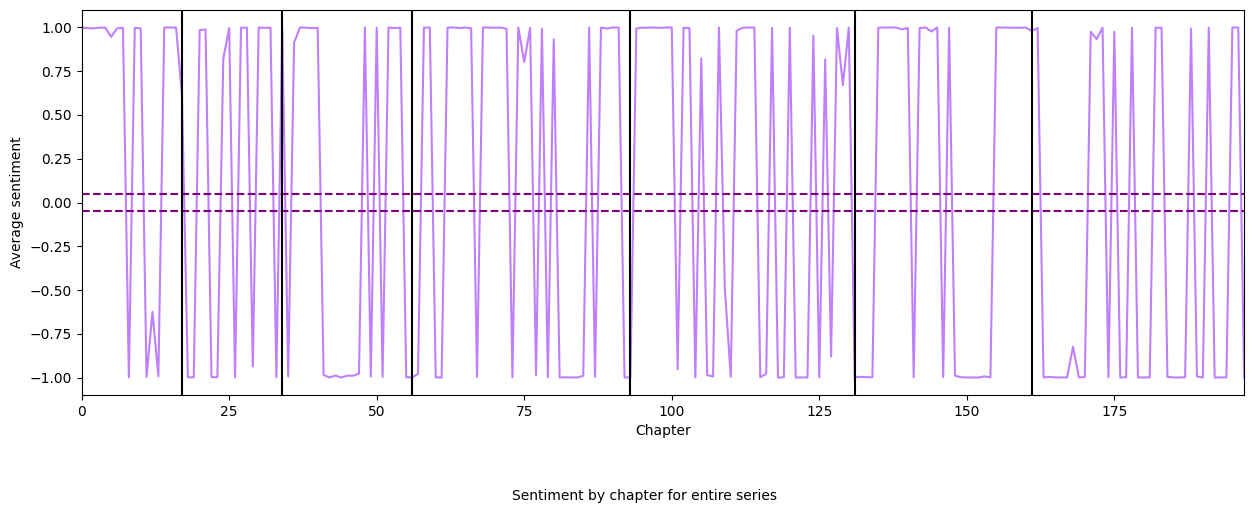

In [17]:
sent_by_chapter = "Sentiment by chapter for entire series"
plt.rcParams['figure.figsize'] = [15, 5]
plot_sentiments([("Sentiment for series", series_sent)], sent_by_chapter, book_list_wchapter, False)

In [19]:
# Create character tuple list
import csv
import os

characters = []

with open("HP_characters.csv", "r", encoding="utf8") as sent_file:
    csv = csv.reader(sent_file, delimiter=",")
    for row in csv:
        name = row[0].replace(' ', '_')
        parentage = row[1]
        house = row[2]
        occupation = row[3]
        characters.append((name, parentage, house, occupation))



In [20]:
character_names = [n for n, b, h, o in characters]

In [25]:
avgsent_chars_series = []
for book in book_list:
    tmp_series = sent_chars_book(character_names, book)
    avgsent_chars_series += avgsent_group(tmp_series)

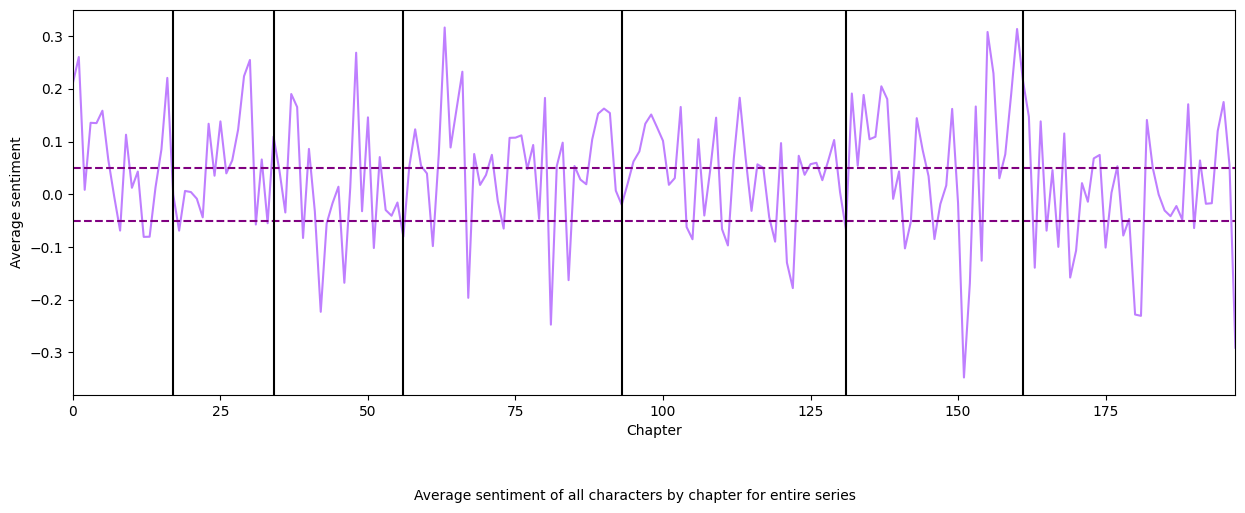

In [26]:
plot_text = "Average sentiment of all characters by chapter for entire series"
plot_sentiments([("Average sentiment of characters", avgsent_chars_series)], plot_text, book_list_wchapter, False)

## Sentiment for houses

In [ ]:
# Create character tuple list

In [27]:
gryffindors = [n for n, p, h, o in characters if h == "Gryffindor"]
hufflepuffs = [n for n, p, h, o in characters if h == "Hufflepuff"]
ravenclaws = [n for n, p, h, o in characters if h == "Ravenclaw"]
slytherins = [n for n, p, h, o in characters if h == "Slytherin"]

In [28]:
avgsent_gryffindor = []
avgsent_hufflepuff = []
avgsent_ravenclaw = []
avgsent_slytherin = []
for book in ["B1/" , "B2/", "B3/", "B4/", "B5/", "B6/", "B7/"]:
    tmp_gryf = sent_chars_book(gryffindors, book)
    tmp_huff = sent_chars_book(hufflepuffs, book)
    tmp_rave = sent_chars_book(ravenclaws, book)
    tmp_slyt = sent_chars_book(slytherins, book)
    
    avgsent_gryffindor += avgsent_group(tmp_gryf)
    avgsent_hufflepuff += avgsent_group(tmp_huff)
    avgsent_ravenclaw += avgsent_group(tmp_rave)
    avgsent_slytherin += avgsent_group(tmp_slyt)

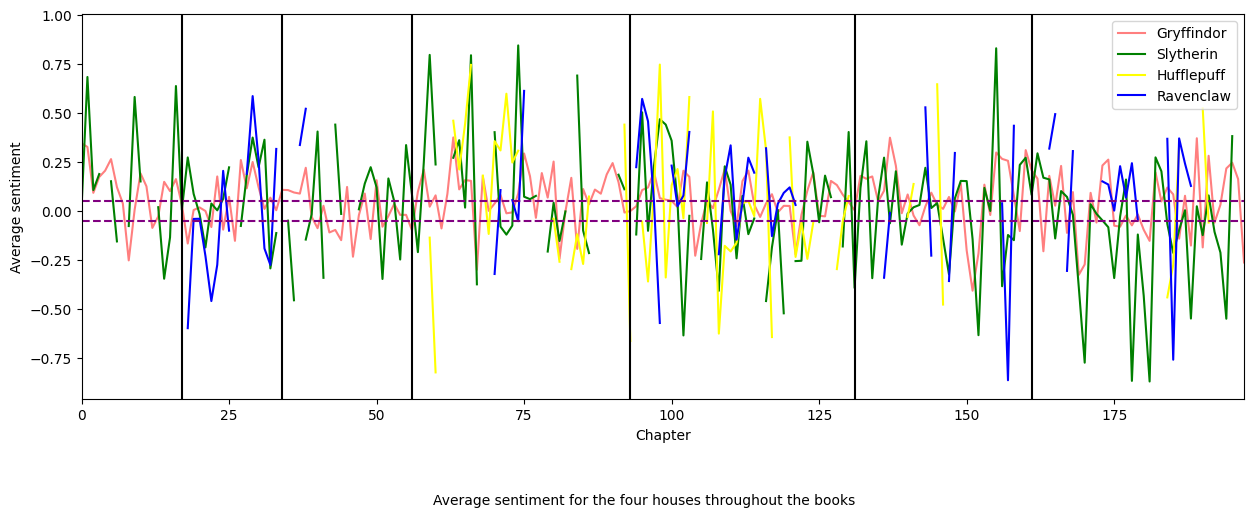

In [29]:
avg_sent_list = [("Gryffindor", avgsent_gryffindor), 
                 ("Slytherin", avgsent_slytherin),
                 ("Hufflepuff", avgsent_hufflepuff),
                 ("Ravenclaw", avgsent_ravenclaw)]
plot_sentiments(avg_sent_list, "Average sentiment for the four houses throughout the books", book_list_wchapter, True)

In [41]:
label = "Gryffindors"
sents = sent_group_and_members(gryffindors, label, book_list)

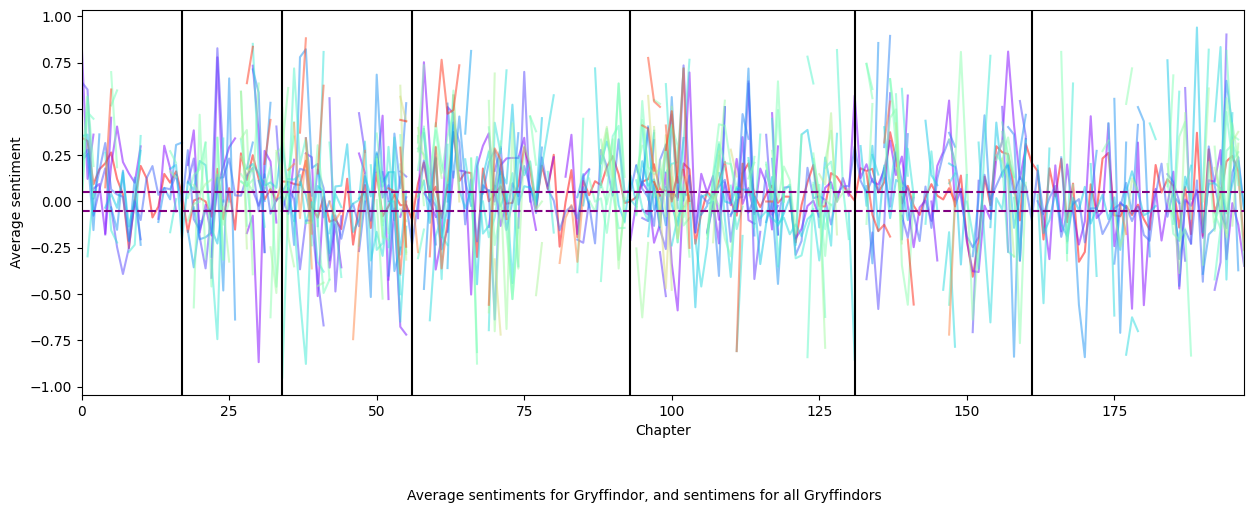

In [43]:
plot_sentiments(sents, "Average sentiments for Gryffindor, and sentimens for all Gryffindors", book_list_wchapter, False)

In [37]:
label = "Slytherins"
sents = sent_group_and_members(slytherins, label, book_list)

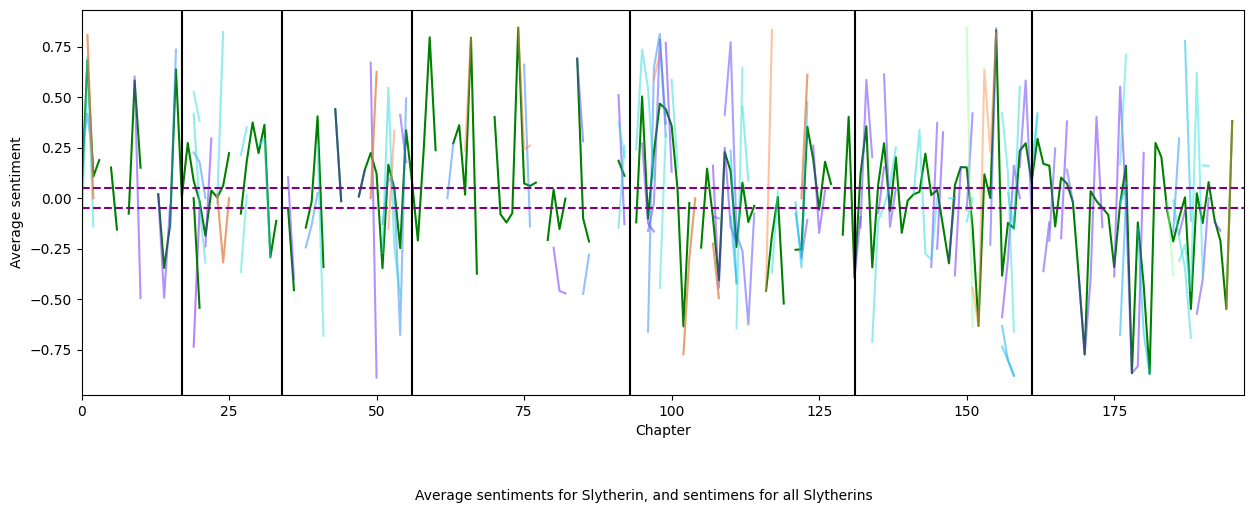

In [40]:
plot_sentiments(sents, "Average sentiments for Slytherin, and sentimens for all Slytherins", book_list_wchapter, False)

In [44]:
label = "Hufflepuffs"
sents = sent_group_and_members(hufflepuffs, label, book_list)

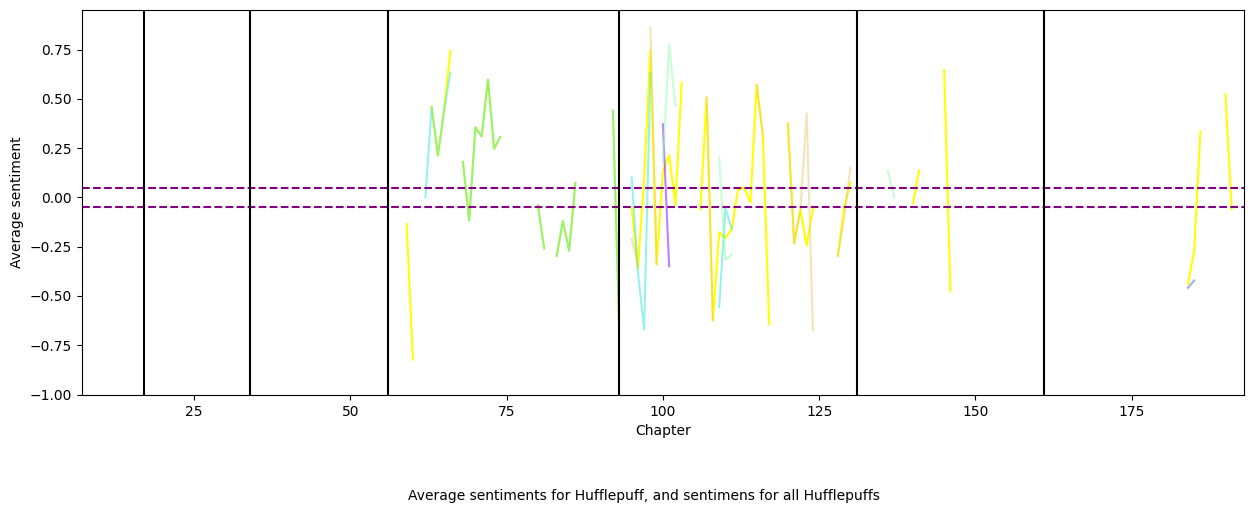

In [45]:
plot_sentiments(sents, "Average sentiments for Hufflepuff, and sentimens for all Hufflepuffs", book_list_wchapter, False)

In [46]:
label = "Ravenclaws"
sents = sent_group_and_members(ravenclaws, label, book_list)

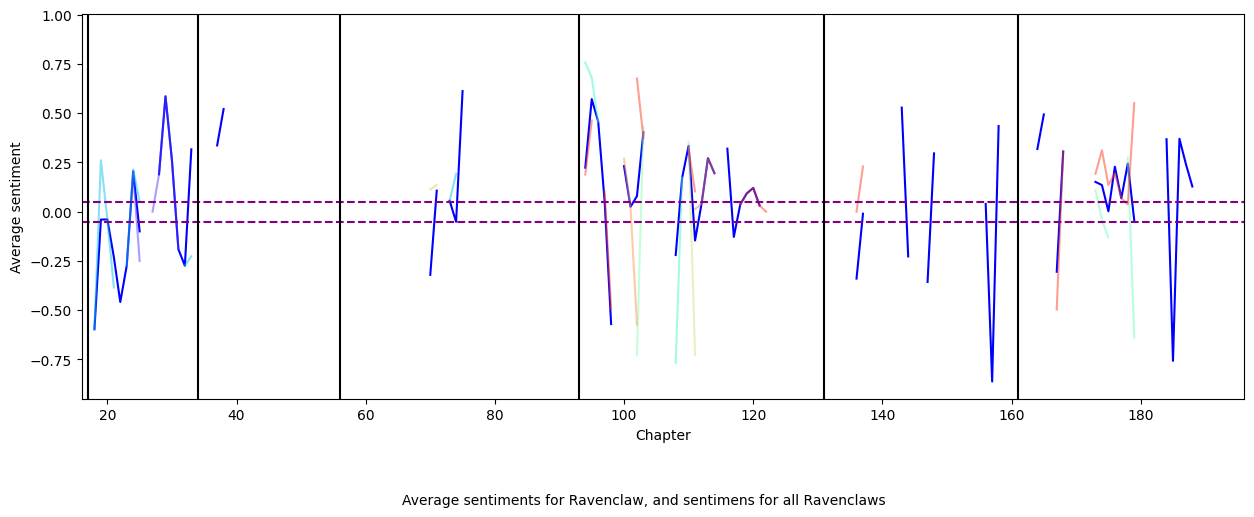

In [47]:
plot_sentiments(sents, "Average sentiments for Ravenclaw, and sentimens for all Ravenclaws", book_list_wchapter, False)